In [ ]:
import cv2
import os
from skimage.filters import sobel
import tensorflow as tf
import requests
import matplotlib.image as mpimg
import sys
import math
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
#from keras.optimizers import SGD
#from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Model

## Chargement des images

In [ ]:
def load_images_from_folder(foldername):
    images = []
    for filename in os.listdir(foldername):
        img = cv2.imread(os.path.join(foldername,filename))
        if img is not None:
            images.append(img)
    return images

In [ ]:
img_list=load_images_from_folder("/content/drive/MyDrive/teleradiographie_de_profil_22")

## Redimensionner les images (500 x 500)

In [ ]:
def resize_img(img, width, height):
    img = cv2.resize(img, (width, height))
    return img

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = {}
for i in range(len(img_list)):
    data[f"img{i + 1}"] = resize_img(img_list[i], 500, 500)

## Visualiser les positions des points N

In [ ]:
def click_event(event, x, y, flags, params):

	# checking for left mouse clicks
	if event == cv2.EVENT_LBUTTONDOWN:

		# displaying the coordinates
		# on the Shell
		print(x, ' ', y)

		# displaying the coordinates
		# on the image window
		font = cv2.FONT_HERSHEY_SIMPLEX
		cv2.putText(img, str(x) + ',' +
					str(y), (x,y), font,
					1, (255, 0, 0), 2)
		cv2.imshow('image', img)

	# checking for right mouse clicks	
	if event==cv2.EVENT_RBUTTONDOWN:

		# displaying the coordinates
		# on the Shell
		print(x, ' ', y)

		# displaying the coordinates
		# on the image window
		font = cv2.FONT_HERSHEY_SIMPLEX
		b = img[y, x, 0]
		g = img[y, x, 1]
		r = img[y, x, 2]
		cv2.putText(img, str(b) + ',' +
					str(g) + ',' + str(r),
					(x,y), font, 1,
					(255, 255, 0), 2)
		cv2.imshow('image', img)

# driver function
if __name__=="__main__":

	# reading the image
	img = data['img1']
    

	img = cv2.resize(img, (500, 500))
	cv2.imshow('image', img)

	# setting mouse handler for the image
	# and calling the click_event() function
	cv2.setMouseCallback('image', click_event)

	# wait for a key to be pressed to exit
	cv2.waitKey(0)

	# close the window
	cv2.destroyAllWindows()

## Extraire les images

In [ ]:
#225 - 110 = 115 et 115/5 = 23 ligne
#415 - 310 = 105 et 105/5 = 21 colonne
#13
def extract_imgs(img, width, height):
    img = resize_img(img, 500, 500)
    imgs_list = []
    for i in range(270, 350, 5):
        for j in range(360, 425, 5):
            new_img = img[i:i + width, j:j + height]
            new_img = new_img/255.0
            new_img = cv2.resize(new_img, (100, 100))
            imgs_list.append(new_img)
    return imgs_list

In [ ]:
def extract_pointS_imgs(img, width, height):
    img = resize_img(img, 500, 500)
    imgs_list = []
    for i in range(180, 280, 5):
        for j in range(220, 305, 5):
            new_img = img[i:i + width, j:j + height]
            new_img = new_img/255.0
            new_img = cv2.resize(new_img, (100, 100))
            imgs_list.append(new_img)
    return imgs_list

In [ ]:
def extract_pointN_imgs(img, width, height):
    img = resize_img(img, 500, 500)
    imgs_list = []
    for i in range(110, 225, 5):
        for j in range(310, 415, 5):
            new_img = img[i:i + width, j:j + height]
            new_img = new_img/255.0
            new_img = cv2.resize(new_img, (100, 100))
            imgs_list.append(new_img)
    return imgs_list

In [ ]:
imList = extract_imgs(img_list[0], 50, 50)

In [ ]:
len(imList)

483

## Sauvegarder les images

In [ ]:
NEG_PATH = os.path.join('/content/drive/MyDrive/pointAdata', 'negative')
POS_PATH = os.path.join('/content/drive/MyDrive/pointAdata', 'positive')
ANC_PATH = os.path.join('/content/drive/MyDrive/pointAdata', 'anchor')

In [ ]:
os.makedirs(NEG_PATH)
os.makedirs(POS_PATH)
os.makedirs(ANC_PATH)

In [ ]:
import uuid

In [ ]:
def save_imgs(list_imgs):
    for i in range(len(list_imgs)):
        img = list_imgs[i]
        img = cv2.resize(img, (500, 500))
        filename = os.path.join(NEG_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(filename, img)  

In [ ]:
for i in range(1,len(img_list)):
    images = extract_imgs(img_list[i], 50, 50)
    save_imgs(images)

NameError: ignored

## Dta augmentation

In [ ]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        # img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    return data

In [ ]:
import uuid

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(800)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(800)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(800)

## Data normalization

In [ ]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    #img = cv2.Canny(img, 40, 40)
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
samples = data.as_numpy_iterator()
example = samples.next()

In [ ]:
res = preprocess_twin(*example)

In [ ]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [ ]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(340)
train_data = train_data.prefetch(170)

In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(340)
test_data = test_data.prefetch(170)

In [ ]:
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [ ]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
embedding = make_embedding()

In [ ]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

## Siamese distance

In [ ]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
l1 = L1Dist()

In [ ]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [ ]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [ ]:
siamese_layer = L1Dist()

In [ ]:
distances = siamese_layer(inp_embedding, val_embedding)

In [ ]:
classifier = Dense(1, activation='sigmoid')(distances)

In [ ]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## Make siamese model

In [ ]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_model = make_siamese_model()

In [ ]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [ ]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [ ]:
checkpoint_dir = './content/drive/MyDrive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [ ]:
# @tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        # if epoch % 10 == 0: 
        #     checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
EPOCHS = 100

In [ ]:
train(train_data, EPOCHS)


 Epoch 1/100
tf.Tensor(0.6929213, shape=(), dtype=float32)
3/3 [==============================] - 91s 8s/step
0.667922 0.0 0.0

 Epoch 2/100
tf.Tensor(0.6693747, shape=(), dtype=float32)
3/3 [==============================] - 23s 6s/step
0.6435418 0.0 0.0

 Epoch 3/100
tf.Tensor(0.6669447, shape=(), dtype=float32)
3/3 [==============================] - 25s 7s/step
0.61139905 0.0 0.0

 Epoch 4/100
tf.Tensor(0.6439771, shape=(), dtype=float32)
3/3 [==============================] - 25s 7s/step
0.6579075 0.002793296 0.33333334

 Epoch 5/100
tf.Tensor(0.65325946, shape=(), dtype=float32)
3/3 [==============================] - 25s 7s/step
0.5965844 0.0028248588 1.0

 Epoch 6/100
tf.Tensor(0.64724505, shape=(), dtype=float32)
3/3 [==============================] - 25s 7s/step
0.6537327 0.011019284 0.8

 Epoch 7/100
tf.Tensor(0.6545556, shape=(), dtype=float32)
3/3 [==============================] - 27s 7s/step
0.6562407 0.04278075 0.8888889

 Epoch 8/100
tf.Tensor(0.64762115, shape=(), dtyp

In [ ]:
# Save weights
siamese_model.save('point_A_model_1.h5')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/point_A_model_1.h5', compile=False,
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
pointSmodel = tf.keras.models.load_model('/content/drive/MyDrive/point_S_model_5.h5', compile=False,
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
pointNmodel = tf.keras.models.load_model('/content/drive/MyDrive/point_N_model_1.h5', compile=False,
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
i = 1
j = 1
while(i<(340*2)):
    plt.figure(figsize = (20, 400))
    #a = str(model.predict([test_input[j-1:j], test_val[j-1:j]]))
    a = "Sim = " + str(model.predict([test_input[j-1:j], test_val[j-1:j]])[0][0].round(3))
    plt.subplot(340, 2, i)
    plt.imshow(test_input[j-1])
    i += 1
    plt.subplot(340, 2, i)
    plt.imshow(test_val[j-1])
    i += 1
    plt.title(a)
    j += 1
    plt.show()

In [ ]:
point_A_images1 = []
point_A_images2 = []
point_A_images3 = []
#img = cv2.imread('p1.jpeg')
img1 = cv2.imread('/content/drive/MyDrive/pointAdata/positive/1b90e244-19bb-11ed-8602-0242ac1c0002.jpg')
img2 = cv2.imread('/content/drive/MyDrive/pointAdata/positive/1ccedeb8-19bb-11ed-8602-0242ac1c0002.jpg')
img3 = cv2.imread('/content/drive/MyDrive/pointAdata/positive/2bd6e98c-19bb-11ed-8602-0242ac1c0002.jpg')
#img = img/255.0
img1 = img1/255.0
img2 = img2/255.0
img3 = img3/255.0
#img = cv2.resize(img, (100, 100))
img1 = cv2.resize(img1, (100, 100))
img2 = cv2.resize(img2, (100, 100))
img3 = cv2.resize(img3, (100, 100))
for i in range(208):
    #point_S_images.append(img)
    point_A_images1.append(img1)
    point_A_images2.append(img2)
    point_A_images3.append(img3)

In [ ]:
point_S_images = []
point_S_images1 = []
point_S_images2 = []
point_S_images3 = []
imgs = cv2.imread('/content/drive/MyDrive/p1 (1).jpeg')
imgs1 = cv2.imread('/content/drive/MyDrive/p2.jpg')
imgs2 = cv2.imread('/content/drive/MyDrive/p3.jpg')
imgs3 = cv2.imread('/content/drive/MyDrive/p4.jpg')
imgs = imgs/255.0
imgs1 = imgs1/255.0
imgs2 = imgs2/255.0
imgs3 = imgs3/255.0
imgs = cv2.resize(imgs, (100, 100))
imgs1 = cv2.resize(imgs1, (100, 100))
imgs2 = cv2.resize(imgs2, (100, 100))
imgs3 = cv2.resize(imgs3, (100, 100))
for i in range(340):
    point_S_images.append(imgs)
    point_S_images1.append(imgs1)
    point_S_images2.append(imgs2)
    point_S_images3.append(imgs3)

In [ ]:
#point_S_images = []
point_N_images1 = []
point_N_images2 = []
point_N_images3 = []
#img = cv2.imread('p1.jpeg')
imgn1 = cv2.imread('/content/drive/MyDrive/point_N_data/positive/002422be-18bc-11ed-a6a1-0242ac1c0002.jpg')
imgn2 = cv2.imread('/content/drive/MyDrive/point_N_data/positive/e534cb58-1969-11ed-8bee-0242ac1c0002.jpg')
imgn3 = cv2.imread('/content/drive/MyDrive/point_N_data/positive/ec13b876-1969-11ed-8bee-0242ac1c0002.jpg')
#img = img/255.0
imgn1 = imgn1/255.0
imgn2 = imgn2/255.0
imgn3 = imgn3/255.0
#img = cv2.resize(img, (100, 100))
imgn1 = cv2.resize(imgn1, (100, 100))
imgn2 = cv2.resize(imgn2, (100, 100))
imgn3 = cv2.resize(imgn3, (100, 100))
for i in range(351):
    #point_S_images.append(img)
    point_N_images1.append(imgn1)
    point_N_images2.append(imgn2)
    point_N_images3.append(imgn3)

In [ ]:
point_A_data1 = np.array(point_A_images1)
point_A_data2 = np.array(point_A_images2)
point_A_data3 = np.array(point_A_images3)

In [ ]:
point_S_data = np.array(point_S_images)
point_S_data1 = np.array(point_S_images1)
point_S_data2 = np.array(point_S_images2)
point_S_data3 = np.array(point_S_images3)

In [ ]:
point_N_data1 = np.array(point_N_images1)
point_N_data2 = np.array(point_N_images2)
point_N_data3 = np.array(point_N_images3)

In [ ]:
def make_prediction(img):
    #extraction des images 50 x 50
    list_imgs = extract_imgs(img, 50, 50)
    np_data = np.array(list_imgs)
    res = get_index(np_data)
    #193   
    a = int(270 + (5 * int(res[1]/13)))
    b = a + 50
    c = int(360 + (5*(round(13 * ((res[1]/13) - int(res[1]/13)))))-10) 
    d = c + 50
    # les cordonnées du centre du rectangle
    corr = (c+25, b-25)
    image = cv2.resize(img, (500, 500))
    image_with_rectangle1 = cv2.rectangle(
            img = image,
            pt1 = (c , a),
            pt2 = (d, b),
            color = (0, 0, 255), 
            thickness = 1
        )
    # plt.imshow(image_with_rectangle1)
    # plt.title("Sim = "+ str(res[0]))
    return (image_with_rectangle1,corr)

In [ ]:
def make_prediction_pointS(img):
    #extraction des images 50 x 50
    list_imgs = extract_pointS_imgs(img, 50, 50)
    np_data = np.array(list_imgs)
    res = get_index_pointS(np_data)
    #193   
    a = int(180 + (5 * int(res[1]/17)))
    b = a + 50
    c = int(220 + (5*(round(17 * ((res[1]/17) - int(res[1]/17)))))-10) 
    d = c + 50
    # les cordonnées du centre du rectangle
    corr = (c+25, b-25)
    image = cv2.resize(img, (500, 500))
    image_with_rectangle1 = cv2.rectangle(
            img = image,
            pt1 = (c , a),
            pt2 = (d, b),
            color = (255, 0, 255), 
            thickness = 1
        )
    # plt.imshow(image_with_rectangle1)
    # plt.title("Sim = "+ str(res[0]))
    return (image_with_rectangle1, corr)

In [ ]:
def make_prediction_pointN(img):
    #extraction des images 50 x 50
    list_imgs = extract_pointN_imgs(img, 50, 50)
    np_data = np.array(list_imgs)
    res = get_index_pointN(np_data)
    #193   
    a = int(110 + (5 * int(res[1]/21)))
    b = a + 50
    c = int(310 + (5*(round(21 * ((res[1]/21) - int(res[1]/21)))))-10) 
    d = c + 50
    # les cordonnées du centre du rectangle
    corr = (c+25, b-25)
    image = cv2.resize(img, (500, 500))
    image_with_rectangle1 = cv2.rectangle(
            img = image,
            pt1 = (c , a),
            pt2 = (d, b),
            color = (255, 255, 0), 
            thickness = 1
        )
    # plt.imshow(image_with_rectangle1)
    # plt.title("Sim = "+ str(res[0]))
    return (image_with_rectangle1, corr)

In [ ]:

def get_index(np_data):
    j = 1
    sim = 0
    sim_index = 0
    while(j<208):
        #plt.figure(figsize = (300, 300))
        #a = model.predict([point_S_data[j-1:j], np_data[j-1:j]])[0][0].round(3)
        b = model.predict([point_A_data1[j-1:j], np_data[j-1:j]])[0][0].round(3)
        c = model.predict([point_A_data2[j-1:j], np_data[j-1:j]])[0][0].round(3)
        d = model.predict([point_A_data3[j-1:j], np_data[j-1:j]])[0][0].round(3)

        res = ((b+ c + d)/3).round(3)
        if (res > sim):
            sim = res
            sim_index = j + 1
        j += 1
    return (sim, sim_index)

In [ ]:
def get_index_pointS(np_data):
    j = 1
    sim = 0
    sim_index = 0
    while(j<340):
        #plt.figure(figsize = (300, 300))
        a = pointSmodel.predict([point_S_data[j-1:j], np_data[j-1:j]])[0][0].round(3)
        b = pointSmodel.predict([point_S_data1[j-1:j], np_data[j-1:j]])[0][0].round(3)
        c = pointSmodel.predict([point_S_data2[j-1:j], np_data[j-1:j]])[0][0].round(3)
        d = pointSmodel.predict([point_S_data3[j-1:j], np_data[j-1:j]])[0][0].round(3)

        res = ((a + b+ c + d)/4).round(3)
        if (res > sim):
            sim = res
            sim_index = j + 1
        j += 1
    return (sim, sim_index)

In [ ]:
def get_index_pointN(np_data):
    j = 1
    sim = 0
    sim_index = 0
    while(j<351):
        #plt.figure(figsize = (300, 300))
        #a = model.predict([point_S_data[j-1:j], np_data[j-1:j]])[0][0].round(3)
        b = pointNmodel.predict([point_N_data1[j-1:j], np_data[j-1:j]])[0][0].round(3)
        c = pointNmodel.predict([point_N_data2[j-1:j], np_data[j-1:j]])[0][0].round(3)
        d = pointNmodel.predict([point_N_data3[j-1:j], np_data[j-1:j]])[0][0].round(3)

        res = ((b+ c + d)/3).round(3)
        if (res > sim):
            sim = res
            sim_index = j + 1
        j += 1
    return (sim, sim_index)

## Calcul des angles

In [ ]:
# Python program for slope of line
def slope(x1, y1, x2, y2):
    if(x2 - x1 != 0):
      return (float)(y2-y1)/(x2-x1)
    return sys.maxint

In [ ]:
from math import atan

In [ ]:
# Function to find the
# angle between two lines
def findAngle(M1, M2):
    PI = 3.14159265
     
    # Store the tan value  of the angle
    angle = abs((M2 - M1) / (1 + M1 * M2))
 
    # Calculate tan inverse of the angle
    ret = atan(angle)
 
    # Convert the angle from
    # radian to degree
    val = (ret * 180) / PI
 
    # return the result
    return round(val, 4)

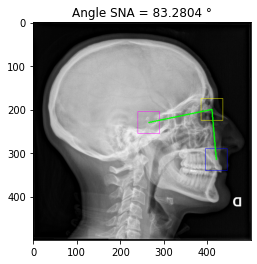

In [ ]:
img = cv2.imread('/content/drive/MyDrive/teleradiographie_de_profil_22/t12.jpg')
result1 = make_prediction(img)
img = result1[0]
result2 = make_prediction_pointS(img)
img = result2[0]
result3 = make_prediction_pointN(img)
img = result3[0]
img = cv2.line(img, result1[1], result3[1], (0, 255, 0), 2)
img = cv2.line(img, result3[1], result2[1], (0, 255, 0), 2)
angle = findAngle(slope(result1[1][0], result1[1][1], result3[1][0], result3[1][1]), slope(result3[1][0], result3[1][1], result2[1][0], result2[1][1]))
plt.title("Angle SNA = " + str(angle) + " °")
plt.imshow(img)

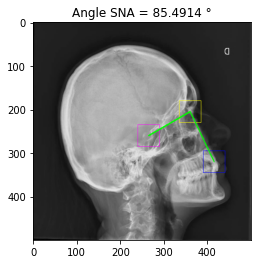

In [ ]:
img = cv2.imread('/content/drive/MyDrive/teleradiographie_de_profil_22/t18.jpg')
result1 = make_prediction(img)
img = result1[0]
result2 = make_prediction_pointS(img)
img = result2[0]
result3 = make_prediction_pointN(img)
img = result3[0]
img = cv2.line(img, result1[1], result3[1], (0, 255, 0), 2)
img = cv2.line(img, result3[1], result2[1], (0, 255, 0), 2)
angle = findAngle(slope(result1[1][0], result1[1][1], result3[1][0], result3[1][1]), slope(result3[1][0], result3[1][1], result2[1][0], result2[1][1]))
plt.title("Angle SNA = " + str(angle) + " °")
plt.imshow(img)


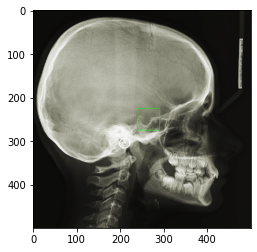

In [ ]:
img = cv2.imread('/content/drive/MyDrive/cas1.png')
# result1 = make_prediction(img)
# img = result1[0]
result = make_prediction_pointS(img)
#img = result2[0]
# result3 = make_prediction_pointN(img)
# img = result3[0]
# img = cv2.line(img, result1[1], result3[1], (0, 255, 0), 2)
# img = cv2.line(img, result3[1], result2[1], (0, 255, 0), 2)
# angle = findAngle(slope(result1[1][0], result1[1][1], result3[1][0], result3[1][1]), slope(result3[1][0], result3[1][1], result2[1][0], result2[1][1]))
# plt.title("Angle SNA = " + str(angle))
plt.imshow(result[0])